#### home

In [27]:
import sys
sys.path.append('/data/dotfiles_xy/nvim/plugged/kaggle-web-traffic')
from tensorflow.python.framework.graph_util import convert_variables_to_constants
# %load -r 1-18 /data/dotfiles_xy/nvim/plugged/kaggle-web-traffic/trainer.py
import matplotlib.pyplot as plt
%matplotlib inline
import os.path
import shutil
import sys
import numpy as np
import tensorflow as tf
from tqdm import trange
from typing import List, Tuple
import heapq
import logging
import pandas as pd
from enum import Enum

from hparams import build_from_set, build_hparams
from feeder import VarFeeder
from input_pipe import InputPipe, ModelMode, Splitter,FakeSplitter, page_features
from model import Model
import argparse
from util import *
from IPython.display import clear_output,Image,display,HTML

seed=5
train_sampling=1
eval_sampling=1
side_split=True

In [26]:
v=pipe.iterator.get_next()

In [2]:
# %load -r 12-29 /data/dotfiles_xy/nvim/plugged/kaggle-web-traffic/make_features.py

def read_cached(name) -> pd.DataFrame:
    """
    Reads csv file (maybe zipped) from data directory and caches it's content as a pickled DataFrame
    :param name: file name without extension
    :return: file content
    """
    cached = 'data/%s.pkl' % name
    sources = ['data/%s.csv' % name, 'data/%s.csv.zip' % name]
    if os.path.exists(cached):
        return pd.read_pickle(cached)
    else:
        for src in sources:
            if os.path.exists(src):
                df = pd.read_csv(src)
                df.to_pickle(cached)
                return df


In [ ]:
import dill
# dill.load_session('./data/vars/make_feature.db')

f=open('./data/vars/checkpoint.pkl','rb')
page_map=dill.load(f)
f.close()

page_map.shape

1


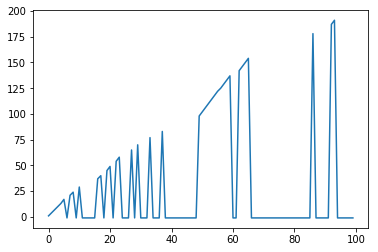

In [44]:
from skimage.io import imshow
%matplotlib inline
plt.plot(page_map[:100,i])
# plt.plot(page_map.reshape(-1,1)[:10000])
i=i+1
print(i)

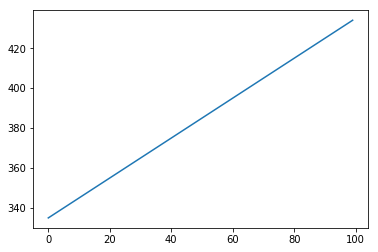

In [34]:
x+=100
# i+=1
plt.plot(lagged_ix[x:x+100,i])

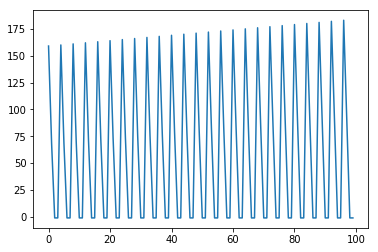

In [35]:
x=1000
plt.plot(lagged_ix.reshape(-1,1)[x:x+100])

In [36]:
import dill
# dill.load_session('./data/vars/make_feature.db')

f=open('./data/vars/checkpoint.pkl','rb')
page_features=dill.load(f)
f.close()

page_features.shape

(145036, 3)

In [37]:
page_features.describe()

,agent,site,country
count,145036,145036,127181
unique,4,3,7
top,all-access_all-agents,wikipedia.org,en
freq,39402,127181,24081


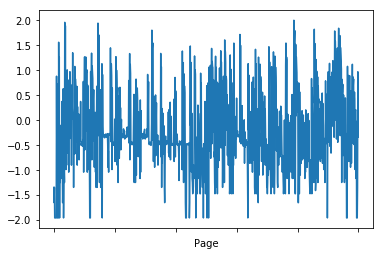

In [41]:
page_pop[:1000].plot()

In [42]:
import dill
# dill.load_session('./data/vars/make_feature.db')

f=open('./data/vars/checkpoint.pkl','rb')
dow=dill.load(f)
f.close()

dow.shape

(867, 2)

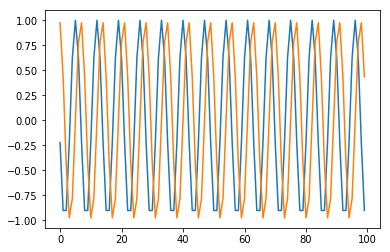

In [44]:
plt.plot(dow[:100,:])

In [1]:
# %load -r 1-11 /data/dotfiles_xy/nvim/plugged/kaggle-web-traffic/make_features.py
import pandas as pd
import numpy as np
import os.path
import os
import argparse

import extractor
from feeder import VarFeeder
import numba
from typing import Tuple, Dict, Collection, List


/root/anaconda/envs/p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# %load -r 219-243 /data/dotfiles_xy/nvim/plugged/kaggle-web-traffic/make_features.py
def uniq_page_map(pages:Collection):
    """
    Finds agent types (spider, desktop, mobile, all) for each unique url, i.e. groups pages by agents
    :param pages: all urls (must be presorted)
    :return: array[num_unique_urls, 4], where each column corresponds to agent type and each row corresponds to unique url.
     Value is an index of page in source pages array. If agent is missing, value is -1
    """
    import re
    result = np.full([len(pages), 4], -1, dtype=np.int32)
    pat = re.compile(
        '(.+(?:(?:wikipedia\.org)|(?:commons\.wikimedia\.org)|(?:www\.mediawiki\.org)))_([a-z_-]+?)')
    prev_page = None
    num_page = -1
    agents = {'all-access_spider': 0, 'desktop_all-agents': 1, 'mobile-web_all-agents': 2, 'all-access_all-agents': 3}
    for i, entity in enumerate(pages):
        match = pat.fullmatch(entity)
        assert match
        page = match.group(1)
        agent = match.group(2)
        if page != prev_page:
            prev_page = page
            num_page += 1
        result[num_page, agents[agent]] = i
    return result[:num_page+1]


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import random
%matplotlib inline
# df=pd.read_csv('/backup/.kaggle/competitions/web-traffic-time-series-forecasting/train_2.csv',nrows=1000)
df=pd.read_csv('/backup/.kaggle/competitions/web-traffic-time-series-forecasting/train_2.csv')

In [8]:
df.columns
# df.shape

Index(['Page', '2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04',
       '2015-07-05', '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09',
       ...
       '2017-09-01', '2017-09-02', '2017-09-03', '2017-09-04', '2017-09-05',
       '2017-09-06', '2017-09-07', '2017-09-08', '2017-09-09', '2017-09-10'],
      dtype='object', length=804)

In [16]:
df.shape

(145063, 804)

In [17]:
import gc
del df
gc.collect()

2790

### graph viz

In [28]:
# from deepdream project
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [48]:
import tensorflow as tf
a=tf.constant(5)
b=tf.constant(6)
c=a*b

In [49]:
graph_def=c.graph.as_graph_def()

In [50]:
strip_consts(graph_def=graph_def)

node {
  name: "feeder_vars/Const"
  op: "Const"
  device: "/device:CPU:0"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
          dim {
            size: 145036
          }
          dim {
            size: 804
          }
        }
        float_val: 0.0
      }
    }
  }
}
node {
  name: "hits"
  op: "VariableV2"
  device: "/device:CPU:0"
  attr {
    key: "container"
    value {
      s: ""
    }
  }
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: 145036
        }
        dim {
          size: 804
        }
      }
    }
  }
  attr {
    key: "shared_name"
    value {
      s: ""
    }
  }
}
node {
  name: "hits/Assign"
  op: "Assign"
  input: "hits"
  input: "feeder_vars/Const"
  device: "/device:CPU:0"
  attr {
    key: "T"
    value {
      type: DT_FLOAT
 

In [13]:
gd=GraphDef('time_x_no_convert')
show_graph(graph_def=gd.graph_def)

[] [] []


In [17]:
gd=GraphDef('time_x_no_convert')
gd.list_tensor('hits')

[] [] []
hits
hits/Assign
hits/read
shfl_hits
shfl_hits_1
shfl_hits_2


In [21]:
gd.get_tensor('import/hits:0')

<tf.Tensor 'import/hits:0' shape=(145036, 804) dtype=float32_ref>

In [23]:
gd=GraphDef('graph')
gd.list_tensor('input')

[] [] []
input


In [25]:
gd=GraphDef('inp')

[] [] []


In [26]:
sess=tf.InteractiveSession()

# with tf.Session() as sess:
import_graph('time_x_no_convert')
# print(sess.graph.get_all_collection_keys())

In [ ]:
# %load -r 52-68 /data/dotfiles_xy/nvim/plugged/kaggle-web-traffic/feeder.py

with tf.Graph().as_default():
    tensor_vars = self._build_vars()
    placeholders = [tf.placeholder(tf.as_dtype(dtype), shape=shape) for dtype, shape in
                    zip(self.dtypes, self.shapes)]
    assigners = [tensor_var.assign(placeholder) for tensor_var, placeholder in
                 zip(tensor_vars, placeholders)]
    feed = {ph: v for ph, v in zip(placeholders, values)}
    saver = tf.train.Saver(self._var_dict(tensor_vars), max_to_keep=1)
    init = tf.global_variables_initializer()

with tf.Session(config=tf.ConfigProto(device_count={'GPU': 0})) as sess:
    sess.run(init)
    sess.run(assigners, feed_dict=feed)
    save_path = os.path.join(path, 'feeder.cpt')
    saver.save(sess, save_path, write_meta_graph=False, write_state=False)


In [3]:
import tensorflow as tf
import dill

def sess_pp(tf):
    sess=tf.InteractiveSession()
    init=tf.global_variables_initializer()
    sess.run(init)
    return sess

def graph_of(fn):
    with open(f'./data/vars/{fn}.pkl','rb') as f:
        return dill.load(f)

### placeholder

In [10]:
import dill
with open('./data/vars/checkpoint.pkl','rb') as f:
    ph=dill.load(f)
# ph=dill.load(open('./data/vars/checkpoint.pkl','rb'))


import dill
with open('./data/vars/checkpoint_var.pkl','rb') as f:
    values=dill.load(f)
# ph=dill.load(open('./data/vars/checkpoint.pkl','rb'))


import dill
with open('./data/vars/checkpoint_feed.pkl','rb') as f:
    feed=dill.load(f)
# ph=dill.load(open('./data/vars/checkpoint.pkl','rb'))

In [2]:
ph=[tf.placeholder(tf.as_dtype(tf.float32),shape=(145036,1))]

v1=np.ones(shape=(145036,1))
v2=np.ones(shape=(145036,1))

values=[v1,v2]

In [5]:
v=[tf.maximum(each,0) for each in ph[7:9]]

#### run simple session

In [15]:
ph=[tf.placeholder(tf.as_dtype(each.dtype),shape=each.shape) for each in values]
# /len ph
feed={p:inp for p,inp in zip(ph,values)}
# /len feed

sess=sess_pp()
v=[each for each in ph]

r=sess.run(v,feed)

[each.shape for each in r]

11

In [49]:
tf.train.write_graph(sess.graph.as_graph_def(), output_fld, f, as_text=True)

NameError: name 'output_fld' is not defined

In [39]:
/dir tf.GraphDef

['ByteSize',
 'Clear',
 'ClearExtension',
 'ClearField',
 'CopyFrom',
 'DESCRIPTOR',
 'DiscardUnknownFields',
 'Extensions',
 'FindInitializationErrors',
 'FromString',
 'HasExtension',
 'HasField',
 'IsInitialized',
 'LIBRARY_FIELD_NUMBER',
 'ListFields',
 'MergeFrom',
 'MergeFromString',
 'NODE_FIELD_NUMBER',
 'ParseFromString',
 'RegisterExtension',
 'SerializePartialToString',
 'SerializeToString',
 'SetInParent',
 'VERSIONS_FIELD_NUMBER',
 'VERSION_FIELD_NUMBER',
 'WhichOneof',
 '_CheckCalledFromGeneratedFile',
 '_SetListener',
 '__class__',
 '__deepcopy__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '_extensions_by_name',
 '_extensions_b

#### loading the model

In [27]:
from lucid.modelzoo.vision_base import Model

In [ ]:
# %load -n Model
class Model(object):
  """Base pretrained model importer."""

  model_path = None
  labels_path = None
  labels = None
  image_value_range = (-1, 1)
  image_shape = [None, None, 3]

  def __init__(self):
    self.graph_def = None
    if self.labels_path is not None:
      self.labels = load_text_labels(self.labels_path)

  def load_graphdef(self):
    self.graph_def = load_graphdef(self.model_path)

  def post_import(self, scope):
    pass

  def create_input(self, t_input=None, forget_xy_shape=True):
    """Create input tensor."""
    if t_input is None:
      t_input = tf.placeholder(tf.float32, self.image_shape)
    t_prep_input = t_input
    if len(t_prep_input.shape) == 3:
      t_prep_input = tf.expand_dims(t_prep_input, 0)
    if forget_xy_shape:
      t_prep_input = forget_xy(t_prep_input)
    lo, hi = self.image_value_range
    t_prep_input = lo + t_prep_input * (hi-lo)
    return t_input, t_prep_input

  def import_graph(self, t_input=None, scope='import', forget_xy_shape=True):
    """Import model GraphDef into the current graph."""
    graph = tf.get_default_graph()
    assert graph.unique_name(scope, False) == scope, (
        'Scope "%s" already exists. Provide explicit scope names when '
        'importing multiple instances of the model.') % scope
    t_input, t_prep_input = self.create_input(t_input, forget_xy_shape)
    tf.import_graph_def(
        self.graph_def, {self.input_name: t_prep_input}, name=scope)
    self.post_import(scope)

In [10]:
%%file graph_of.py
from lucid.misc.io.reading import read

# the_string=read('/opt/playground/databowl.pb')
# the_string=read('./data/vars/sess_graph.pb')
def graph_of(f):
    the_string=read(f'./data/vars/{f}.pb')
    graph_def=tf.GraphDef.FromString(the_string)
    return graph_def

Writing graph_of.py


#### tf Variable

In [8]:
# tf.Variable(11)
b=2*tf.Variable(11)
b

<tf.Tensor 'mul:0' shape=() dtype=int32>

In [9]:
normal_rv = tf.Variable( tf.truncated_normal([2,3],stddev = 0.1))

#initialize the variable
# init_op = tf.global_variables_initializer()

#### local tf variable

#### only get local variable once,if need resuse, use reuse config

In [7]:
init_op=tf.constant(5)

xy=tf.get_local_variable(name='xy',initializer=init_op,dtype=tf.int32)

In [44]:
for i in tf.local_variables():
    print(i.name)
#     print(i.eval(sess))

xy:0


In [45]:
print(sess.run(tf.report_uninitialized_variables()))

[]


In [43]:
sess.run(tf.global_variables_initializer())

### the variable setting and new assign

In [17]:
sess=sess_pp()
b=tf.Variable(9)
p=[]
# init_op=tf.local_variables_initializer()
# xy.initialized_value()
# init_op=tf.constant(10)
# xy.initializer=init_op
# xy.initialized_value()
# sess.run(init_op)
# print(f'the init value fo xy:{xy.initial_value}')
# xy.eval(sess)
sess.run([xy.initializer,b.initializer])
p+=[sess.run([b,xy])]
xy.assign(9)
b.assign(1)
p+=[sess.run([b.assign(1),xy])]
sess.run(xy.initializer)
p+=[sess.run([b,xy])]

In [18]:
p

[[9, 5], [1, 5], [1, 5]]

##### need to mv this ipynb

In [ ]:
# %load -r 17-22 /data/dotfiles_xy/nvim/plugged/jedi-vim/pythonx/parso/docs/conf.py
# add these directories to sys.path here. If the directory is relative to the
# documentation root, use os.path.abspath to make it absolute, like shown here.
sys.path.insert(0, os.path.abspath('..'))
sys.path.append(os.path.abspath('_themes'))

# -- General configuration -----------------------------------------------------

#### inp actually get local variabel,here with no initializer

In [9]:
inp=VarFeeder.read_vars('./data/vars')

inp.hits

<tf.Variable 'hits:0' shape=(145036, 804) dtype=float32_ref>

### restore has the GPU

#### the restore doing a assign

In [26]:
with tf.Session(config=tf.ConfigProto(device_count={'cpu':0})) as sess: 
    inp.restore(sess)
    b=tf.shape(inp['hits'])
    print(b.graph.version,inp.hits.graph.version)
    print(sess.run(tf.report_uninitialized_variables()))
    # inp.hits.eval().shape
    print(sess.run([b,inp.hits]))

INFO:tensorflow:Restoring parameters from ./data/vars/feeder.cpt


INFO:tensorflow:Restoring parameters from ./data/vars/feeder.cpt


313 313
[b'Variable' b'Variable_1']
[array([145036,    804], dtype=int32), array([[1.3862944, 1.609438 , 2.0794415, ..., 1.9459101, 2.3025851,
        2.7080503],
       [0.       , 0.       , 0.6931472, ..., 1.0986123, 0.       ,
        1.609438 ],
       [1.3862944, 1.609438 , 2.0794415, ..., 1.3862944, 1.3862944,
        2.3025851],
       ...,
       [1.609438 , 1.609438 , 1.3862944, ..., 4.406719 , 4.65396  ,
        4.1743875],
       [6.982863 , 7.0992017, 6.985642 , ..., 5.560682 , 5.710427 ,
        5.786897 ],
       [8.377011 , 8.46337  , 8.441175 , ..., 6.8617115, 6.902743 ,
        6.672033 ]], dtype=float32)]


#### exercise

In [20]:
# %load -n restore
def restore(inp, tensor, tf):
    with tf.Session(config=tf.ConfigProto(device_count={'cpu': 0})) as sess:
        inp.restore(sess)
        # b=tf.shape(inp['hits'])
        print(sess.run(tf.report_uninitialized_variables()))
        # inp.hits.eval().shape
        print(sess.run([tensor, inp.hits]))

In [21]:
b=tf.shape(inp['hits'])

In [22]:
from util import restore
restore(inp,b,tf)

INFO:tensorflow:Restoring parameters from ./data/vars/feeder_cpu.cpt


INFO:tensorflow:Restoring parameters from ./data/vars/feeder_cpu.cpt


[b'Variable' b'Variable_1' b'xy']
[array([145036,    804], dtype=int32), array([[1.3862944, 1.609438 , 2.0794415, ..., 1.9459101, 2.3025851,
        2.7080503],
       [0.       , 0.       , 0.6931472, ..., 1.0986123, 0.       ,
        1.609438 ],
       [1.3862944, 1.609438 , 2.0794415, ..., 1.3862944, 1.3862944,
        2.3025851],
       ...,
       [1.609438 , 1.609438 , 1.3862944, ..., 4.406719 , 4.65396  ,
        4.1743875],
       [6.982863 , 7.0992017, 6.985642 , ..., 5.560682 , 5.710427 ,
        5.786897 ],
       [8.377011 , 8.46337  , 8.441175 , ..., 6.8617115, 6.902743 ,
        6.672033 ]], dtype=float32)]


In [ ]:
assign_op=[t.assign(v) for t,v in zip(inp,v)]

#### the breakpoint
the breakpoint is in the model init, the inpipe already finished
inp.time_x is the tensor to check
and the if it in same graph with the restore graph

In [ ]:
# %load src/bk_point_session.py
get_ipython().run_line_magic('whos', '')
get_ipython().run_line_magic('whos', '')
inp
inp.make_features
get_ipython().run_line_magic('edit', 'inp.load_vars')
inp.inp
get_ipython().run_line_magic('edit', 'inp.load_vars')
sess=tf.InteractiveSession()
inp.load_vars(sess)
sess.run(tf.report_uninitialized_variables())
sess.graph.version
inp.time_x
inp.time_x.graph.version
inp.inp.hits.graph.version
sess.run([inp.time_x])


sess=tf.InteractiveSession()
inp.load_vars(sess)
sess.run([inp.time_x])
sess.run(tf.report_uninitialized_variables())

inp.init_iterator(sess)
sess.run(tf.report_uninitialized_variables())
sess.run(tf.report_uninitialized_variables())
sess.run([inp.time_x])
get_ipython().run_line_magic('save', 'bk_point_session ~0/')


In [12]:
def bug_fix(grap_def):
    for node in graph_def.node:
      if node.op == 'RefSwitch':
        node.op = 'Switch'
        for index in xrange(len(node.input)):
          node.input[index] = node.input[index] + '/read'
      elif node.op == 'AssignSub':
        node.op = 'Sub'
        if 'use_locking' in node.attr: del node.attr['use_locking']
      elif node.op == 'Assign':
        if 'use_locking' in node.attr: del node.attr['use_locking']
        for index in range(len(node.input)):
          node.input[index] = node.input[index] + '/read'

##### working on

In [24]:
# pack_graph_def(inp.hits,'inp')
a,b,c=placeholder()


In [32]:
ls ./data/vars/*.pb

./data/vars/cropped_dow.pb*  ./data/vars/tfnode.pb*
./data/vars/graph.pb*        ./data/vars/time_x_no_convert.pb*
./data/vars/inp.pb*          ./data/vars/time_x.pb*
./data/vars/sess_graph.pb*


#####  why the time_x only have 2 node?

In [38]:
# gd=GraphDef('time_x_no_convert')
gd=GraphDef('time_x')

gd.shape()

2

In [5]:
input_map={n+':0':tf.placeholder(tf.as_dtype(p.dtype),p.shape) for n,p in zip(inp.keys(),ph)}

# input_map

from util import graph_of
with tf.Session() as sess:
#     inp.restore(sess)
#     inp.init_iterator()
#     sess.run(tf.report_uninitialized_variables())
#     tfnode='tfnode_timex'
    tfnode='time_xyx'
#     tfnode='inp'
    graph_def=graph_of(tfnode)
#     bug_fix(graph_def)
#     tf.import_graph_def(graph_def,input_map=input_map,name='import')
#     print(sess.graph.get_tensor_by_name('hits:0'))
#     tf.import_graph_def(graph_def,name='import')
#     print(sess.graph.get_tensor_by_name('import/hits:0'))
#     tf.import_graph_def(graph_def,name='import')
    tf.import_graph_def(graph_def,input_map=input_map)
#     sess.run()

NameError: name 'ph' is not defined

In [8]:
with tf.Session() as sess:
    inp.restore(sess)
    print(inp.hits.eval(sess))

INFO:tensorflow:Restoring parameters from ./data/vars/feeder.cpt
[[1.3862944 1.609438  2.0794415 ... 1.9459101 2.3025851 2.7080503]
 [0.        0.        0.6931472 ... 1.0986123 0.        1.609438 ]
 [1.3862944 1.609438  2.0794415 ... 1.3862944 1.3862944 2.3025851]
 ...
 [1.609438  1.609438  1.3862944 ... 4.406719  4.65396   4.1743875]
 [6.982863  7.0992017 6.985642  ... 5.560682  5.710427  5.786897 ]
 [8.377011  8.46337   8.441175  ... 6.8617115 6.902743  6.672033 ]]


In [3]:
sess.graph.get_tensor_by_name('import/hits:0')

<tf.Tensor 'import/hits:0' shape=(145036, 804) dtype=float32_ref>

In [31]:
def import_graph():
    from util import graph_of
    sess=tf.InteractiveSession()
    # graph_def=graph_of('tfnode_timex')
    graph_def=graph_of('inp')
#     tf.import_graph_def(graph_def=graph_def,name='import',input_map=input-map)
    return sess

In [11]:
for each in sess.graph_def.node:
#     if 'Iterator' in each.name:
#     if 'hits' in each.name:
    if 'Assign' in each.name:
        print(each.name)

hits/Assign
lagged_ix/Assign
page_map/Assign
page_ix/Assign
pf_agent/Assign
pf_country/Assign
pf_site/Assign
page_popularity/Assign
year_autocorr/Assign
quarter_autocorr/Assign
dow/Assign
varfeeder_saver/Assign
varfeeder_saver/Assign_1
varfeeder_saver/Assign_2
varfeeder_saver/Assign_3
varfeeder_saver/Assign_4
varfeeder_saver/Assign_5
varfeeder_saver/Assign_6
varfeeder_saver/Assign_7
varfeeder_saver/Assign_8
varfeeder_saver/Assign_9
varfeeder_saver/Assign_10
import/hits/Assign
import/lagged_ix/Assign
import/page_map/Assign
import/page_ix/Assign
import/pf_agent/Assign
import/pf_country/Assign
import/pf_site/Assign
import/page_popularity/Assign
import/year_autocorr/Assign
import/quarter_autocorr/Assign
import/dow/Assign
import/varfeeder_saver/Assign
import/varfeeder_saver/Assign_1
import/varfeeder_saver/Assign_2
import/varfeeder_saver/Assign_3
import/varfeeder_saver/Assign_4
import/varfeeder_saver/Assign_5
import/varfeeder_saver/Assign_6
import/varfeeder_saver/Assign_7
import/varfeeder_sa

In [6]:
inp.hits.name , inp.hits.graph.get_tensor_by_name('hits:0')

('hits:0', <tf.Tensor 'hits:0' shape=(145036, 804) dtype=float32_ref>)

In [10]:
tf.train.Saver({'hits':inp.hits.graph.get_tensor_by_name('hits:0')})

In [8]:
# inp.hits.graph.get_tensor_by_name('hits:0')

timex=sess.graph.get_tensor_by_name('import/m_0/input/IteratorGetNext:1')

init=sess.graph.get_operation_by_name('import/m_0/input/MakeIterator')

hits=sess.graph.get_operation_by_name('import/hits')

In [64]:
sess.graph.get_tensor_by_name('xy:0')

<tf.Tensor 'xy:0' shape=() dtype=int32_ref>

In [9]:
hits,init,timex

(<tf.Operation 'import/hits' type=VariableV2>,
 <tf.Operation 'import/m_0/input/MakeIterator' type=MakeIterator>,
 <tf.Tensor 'import/m_0/input/IteratorGetNext:1' shape=(?, 283, 24) dtype=float32>)

In [7]:
sess=tf.InteractiveSession()
inp.restore(sess)
shape=tuple(inp.hits.shape.as_list())
sess.run(inp.hits.assign(np.random.randn(shape[0],shape[1])))

INFO:tensorflow:Restoring parameters from ./data/vars/feeder.cpt


array([[-0.15802102, -2.622337  , -0.25736943, ..., -0.11215199,
         1.5156751 ,  0.9874038 ],
       [ 1.2723012 ,  0.12282584,  0.22732592, ...,  1.6915259 ,
         0.21756081,  1.5514262 ],
       [ 0.80173683,  0.15458263,  0.59286314, ..., -1.1299784 ,
        -0.00882775, -1.4566824 ],
       ...,
       [-0.3153754 ,  0.3265492 , -0.7217028 , ..., -1.0806404 ,
         0.8204752 ,  0.08231013],
       [-1.0967845 , -0.00670483, -1.2549477 , ..., -0.4351945 ,
         0.68896335, -0.03941388],
       [ 0.35870087, -0.78288215, -0.64257133, ...,  0.32328215,
         0.9688851 , -0.5530278 ]], dtype=float32)

In [5]:
sess=tf.InteractiveSession()
inp.restore(sess)
sess.run(inp.hits)

INFO:tensorflow:Restoring parameters from ./data/vars/feeder.cpt


array([[1.3862944, 1.609438 , 2.0794415, ..., 1.9459101, 2.3025851,
        2.7080503],
       [0.       , 0.       , 0.6931472, ..., 1.0986123, 0.       ,
        1.609438 ],
       [1.3862944, 1.609438 , 2.0794415, ..., 1.3862944, 1.3862944,
        2.3025851],
       ...,
       [1.609438 , 1.609438 , 1.3862944, ..., 4.406719 , 4.65396  ,
        4.1743875],
       [6.982863 , 7.0992017, 6.985642 , ..., 5.560682 , 5.710427 ,
        5.786897 ],
       [8.377011 , 8.46337  , 8.441175 , ..., 6.8617115, 6.902743 ,
        6.672033 ]], dtype=float32)

In [ ]:
# %load -r 351-371 ./src/model.py

class Model:
    def __init__(self, inp: InputPipe, hparams, is_train, seed, graph_prefix=None, asgd_decay=None, loss_mask=None):
        """
        Encoder-decoder prediction model
        :param inp: Input tensors
        :param hparams:
        :param is_train:
        :param seed:
        :param graph_prefix: Subgraph prefix for multi-model graph
        :param asgd_decay: Decay for SGD averaging
        :param loss_mask: Additional mask for losses calculation (one value for each prediction day), shape=[predict_window]
        """
        self.is_train = is_train
        self.inp = inp
        self.hparams = hparams
        self.seed = seed
        self.inp = inp

        encoder_output, h_state, c_state = make_encoder(inp.time_x, inp.encoder_features_depth, is_train, hparams, seed,
                                                        transpose_output=False)

##### graph import exploring

In [ ]:
# %load -r 155-159 /data/anaconda_backup/envs/patent-landscape/lib/python3.5/site-packages/tensorflow/python/framework/importer.py

def import_graph_def(graph_def, input_map=None, return_elements=None,
                     name=None, op_dict=None, producer_op_list=None):
  """Imports the graph from `graph_def` into the current default `Graph`.


In [ ]:
# %load -r 51-67 /data/dotfiles_xy/nvim/plugged/kaggle-web-traffic/feeder.py
        with tf.Graph().as_default():
            tensor_vars = self._build_vars()
            placeholders = [tf.placeholder(tf.as_dtype(dtype), shape=shape) for dtype, shape in
                            zip(self.dtypes, self.shapes)]
            assigners = [tensor_var.assign(placeholder) for tensor_var, placeholder in
                         zip(tensor_vars, placeholders)]
            feed = {ph: v for ph, v in zip(placeholders, values)}
            saver = tf.train.Saver(self._var_dict(tensor_vars), max_to_keep=1)
            init = tf.global_variables_initializer()

            with tf.Session(config=tf.ConfigProto(device_count={'GPU': 0})) as sess:
                sess.run(init)
                sess.run(assigners, feed_dict=feed)
                save_path = os.path.join(path, 'feeder.cpt')
                saver.save(sess, save_path, write_meta_graph=False, write_state=False)

In [ ]:
# %load -r 115-123 /data/dotfiles_xy/nvim/plugged/kaggle-web-traffic/feeder.py

    def restore(self, session):
        """
        Restores variable content
        :param session: current session
        :return: variable list
        """
        self.saver.restore(session, os.path.join(self.path, 'feeder.cpt'))
        return self

In [17]:
%%file src/util.py
def restore(inp,tensor,tf):
#     import tensorflow as tf
    with tf.Session(config=tf.ConfigProto(device_count={'cpu':0})) as sess: 
        inp.restore(sess)
#         b=tf.shape(inp['hits'])
        print(sess.run(tf.report_uninitialized_variables()))
        # inp.hits.eval().shape
        print(sess.run([tensor,inp.hits]))


# %load src/wgd.py
def wgd(tfnode):
    tf.train.write_graph(tfnode.graph.as_graph_def(),'./data/vars','tfnode.pb',as_text=False)
    return tfnode.graph.as_graph_def()

# %load src/dl.py
def dl(var):
    import dill
    with open('./data/vars/checkpoint_timex.pkl','wb') as f:
        dill.dump(var,f)

# %load src/graph_of.py
from lucid.misc.io.reading import read

# the_string=read('/opt/playground/databowl.pb')
# the_string=read('./data/vars/sess_graph.pb')
def graph_of(f):
    the_string=read(f'./data/vars/{f}.pb')
    graph_def=tf.GraphDef.FromString(the_string)
    return graph_def

Overwriting src/util.py


In [24]:
%%file src/util.py
import tensorflow as tf

# %load src/graph_of.py
from lucid.misc.io.reading import read


def restore(inp, tensor, tf):
    with tf.Session(config=tf.ConfigProto(device_count={'cpu': 0})) as sess:
        inp.restore(sess)
        # b=tf.shape(inp['hits'])
        print(sess.run(tf.report_uninitialized_variables()))
        # inp.hits.eval().shape
        print(sess.run([tensor, inp.hits]))


# %load src/wgd.py
def wgd(tfnode, name):
    tf.train.write_graph(
        tfnode.graph.as_graph_def(),
        './data/vars',
        '{tfnode.name}.pb',
        as_text=False)

    return tfnode.graph.as_graph_def()


# unpack the graph_def
def unpack_graph_def():

    # the code,paste from https://tang.su/2017/01/export-TensorFlow-network/
    from google.protobuf import text_format

    with tf.Session() as sess:
        with open('./graph.pb', 'r') as f:
            graph_def = tf.GraphDef()
            text_format.Merge(f.read(), graph_def)
            output = tf.import_graph_def(graph_def, return_elements=['out:0'])
            print(sess.run(output))


# %load src/dl.py
def dl(var):

    import dill

    with open('./data/vars/checkpoint_timex.pkl', 'wb') as f:
        dill.dump(var, f)


# the_string=read('/opt/playground/databowl.pb')
# the_string=read('./data/vars/sess_graph.pb')


def graph_of(f):
    the_string = read(f'./data/vars/{f}.pb')
    graph_def = tf.GraphDef.FromString(the_string)

    return graph_def

Overwriting src/util.py


##### do not define session inside funtion,but saver restore need session, to finish whole assign action

In [29]:
# %load -r 410-413 /data/dotfiles_xy/nvim/plugged/lucid/notebooks/building-blocks/SemanticDictionary.ipynb
with tf.Graph().as_default(), tf.Session():
    t_input = tf.placeholder(tf.float32, [224, 224, 3])
    T = render.import_model(googlenet, t_input, t_input)
    acts = T(layer).eval({t_input: img})[0]

NameError: name 'render' is not defined

#### simple example about writing a feeder

checkpoint save

In [9]:
# Create some variables.
import tensorflow as tf
v1 = tf.get_variable("v1", shape=[3], initializer = tf.zeros_initializer)
v2 = tf.get_variable("v2", shape=[5], initializer = tf.zeros_initializer)

inc_v1 = v1.assign(v1+1)
dec_v2 = v2.assign(v2-1)

# Add an op to initialize the variables.
init_op = tf.global_variables_initializer()

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Later, launch the model, initialize the variables, do some work, and save the
# variables to disk.
with tf.Session() as sess:
  sess.run(init_op)
  # Do some work with the model.
  inc_v1.op.run()
  dec_v2.op.run()
  # Save the variables to disk.
  save_path = saver.save(sess, "/tmp/model.ckpt")
  print("Model saved in path: %s" % save_path)

Model saved in path: /tmp/model.ckpt


checkpoint restore

In [ ]:
tf.reset_default_graph()
# Create some variables.
v1 = tf.get_variable("v1", [3], initializer = tf.zeros_initializer)
v2 = tf.get_variable("v2", [5], initializer = tf.zeros_initializer)

# Add ops to save and restore only `v2` using the name "v2"
saver = tf.train.Saver({"v2": v2})

# Use the saver object normally after that.
with tf.Session() as sess:
  # Initialize v1 since the saver will not.
  v1.initializer.run()
  saver.restore(sess, "/tmp/model.ckpt")

  print("v1 : %s" % v1.eval())
  print("v2 : %s" % v2.eval())

#### loading the VarFeeder to create the local varaible, to be assigned by a placeholder

##### checkpoint packing and unpacking

In [4]:
import dill
f=open('./data/vars/feeder_meta.pkl','rb')
inp=dill.load(f)

inp_vars=inp._var_dict(inp._build_vars())

inp_vars

{'hits': <tf.Variable 'hits:0' shape=(145036, 804) dtype=float32_ref>,
 'lagged_ix': <tf.Variable 'lagged_ix:0' shape=(867, 4) dtype=int16_ref>,
 'page_map': <tf.Variable 'page_map:0' shape=(52752, 4) dtype=int32_ref>,
 'page_ix': <tf.Variable 'page_ix:0' shape=(145036,) dtype=string_ref>,
 'pf_agent': <tf.Variable 'pf_agent:0' shape=(145036, 4) dtype=float32_ref>,
 'pf_country': <tf.Variable 'pf_country:0' shape=(145036, 7) dtype=float32_ref>,
 'pf_site': <tf.Variable 'pf_site:0' shape=(145036, 3) dtype=float32_ref>,
 'page_popularity': <tf.Variable 'page_popularity:0' shape=(145036,) dtype=float32_ref>,
 'year_autocorr': <tf.Variable 'year_autocorr:0' shape=(145036,) dtype=float32_ref>,
 'quarter_autocorr': <tf.Variable 'quarter_autocorr:0' shape=(145036,) dtype=float32_ref>,
 'dow': <tf.Variable 'dow:0' shape=(867, 2) dtype=float32_ref>}

In [2]:
gs=tf.get_variable('global_step',shape=(),dtype=tf.int64)

saver=tf.train.Saver({'global_step':gs })
with tf.Session() as sess:
    saver.restore(sess,'./data/vars/time_x.ckpt-0')
    print(sess.run(gs))
#     out=sess.graph.get_tensor_by_name('m_0/input/IteratorGetNext')
#     for each in sess.graph_def.node:
#         if 'I'
#     print(sess.graph.get_all_collection_keys())
#     print(sess.graph.get_collection('variables'))
    for each in sess.graph_def.node:
        if '/' in each.name:
            print(each.name)
#     print(sess.run(out))

##### grap_def packing and unpacking

In [39]:
import tensorflow as tf
from tensorflow.python.framework.graph_util import convert_variables_to_constants

a = tf.Variable([[3],[4]], dtype=tf.float32, name='a')
b = tf.Variable(4, dtype=tf.float32, name='b')
input_tensor = tf.placeholder(tf.float32, name='input')
output = tf.add((a+b), input_tensor, name='out')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    graph = convert_variables_to_constants(sess, sess.graph_def, ["out"])
    tf.train.write_graph(graph, '.', './data/vars/graph.pb', as_text=False)

import tensorflow as tf

new_input = tf.placeholder(tf.float32, shape=())

with tf.Session() as sess:
    with open('./data/vars/graph.pb', 'rb') as f: 
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read()) 
        output = tf.import_graph_def(graph_def, input_map={'input:0':new_input}, return_elements=['out:0'], name='a') 
#         output = tf.import_graph_def(graph_def, input_map={'hits:0':new_input})
        print(sess.run(output, feed_dict={new_input:4}))

INFO:tensorflow:Froze 2 variables.


INFO:tensorflow:Froze 2 variables.


Converted 2 variables to const ops.
[array([[11.],
       [12.]], dtype=float32)]


In [19]:
gd=GraphDef('graph')

tensor=gd.get_tensor('import/input:0')

[] [] []


In [14]:
tensor

<tf.Tensor 'import/input:0' shape=<unknown> dtype=float32>

In [29]:
gd=GraphDef('time_x_no_convert')

tensor=gd.get_tensor('import/hits:0')
tensor

out=gd.get_tensor('import/input/IteratorGetNext:0')
out

<tf.Tensor 'import/input/IteratorGetNext:0' shape=(?, 283) dtype=float32>

In [12]:
tensor.name

'import/hits:0'

In [25]:
show_graph(gd.graph_def)

In [23]:
out.name

'import/input/IteratorGetNext:0'

In [30]:
with tf.Graph().as_default(),tf.Session() as sess:
    tf.import_graph_def(gd.graph_def,name='import')
    a = tf.Variable([[3],[4]], dtype=tf.float32, name='a')
    b = tf.Variable(4, dtype=tf.float32, name='b')
    tensor=sess.graph.get_tensor_by_name(tensor.name)
#     tensor=sess.graph.get_tensor_by_name(out.name)
#     input_tensor = tf.placeholder(tf.float32, name='input')
    output = tf.add(3, tensor.shape[0].value,name='out')
#     output = tf.add(tf.constant(3),tensor.shape[0].value,name='out')
    sess.run(a.initializer)
#     sess.run(b.initializer)
#     convert_variables_to_constants(sess,sess.graph_def,['out'])
#     graph=convert_variables_to_constants(sess,sess.graph_def,['out'])
    gd.graph_def=sess.graph_def
    print(gd.shape())
    graph=convert_variables_to_constants(sess,sess.graph_def,['out'])
    print(sess.graph.get_tensor_by_name(tensor.name))
    print(sess.graph.get_tensor_by_name('a:0'))
#     print(sess.graph.get_tensor_by_name('a:0'))
#     for each in sess.graph_def.
#         if 'Iter' in each.name:
#             print(each.name)

165
INFO:tensorflow:Froze 0 variables.


INFO:tensorflow:Froze 0 variables.


Converted 0 variables to const ops.
Tensor("import/hits:0", shape=(145036, 804), dtype=float32_ref, device=/device:CPU:0)
Tensor("a:0", shape=(2, 1), dtype=float32_ref)


In [12]:
gd.graph_def=graph

In [21]:
gd.shape()

154

In [14]:
# gd.get_tensor('import/inputs:0')
gd.list_tensor('')

out/x
out/y
out


In [33]:
with tf.Graph().as_default(),tf.Session() as sess:
    tf.import_graph_def(graph,name='xy')

In [22]:
gd.list_tensor('Iter')

input/Iterator
input/MakeIterator
input/IteratorGetNext


In [11]:
with tf.Session() as sess:
    print(sess.graph.get_all_collection_keys())

['local_variables']


In [10]:
with tf.Graph().as_default(),tf.Session() as sess:
    print(sess.graph.get_all_collection_keys())

[]


#### mark

In [26]:
ls ./data/vars/checkpoint_input/

IteratorGetNext.pkl*
